In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV



In [12]:
pip install h5py scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [41]:
import skopt
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [3]:
df = pd.read_csv('final_game_results.csv')

In [20]:
all_season_results_df = df[['team1_id', 'team2_id','game_number_team2', 'win_flag_team1',
       'ortg_team1', 'ast%_team1', 'ts%_team1', 'efg%_team1', 'poss_team1',
       'dreb%_team1', 'oreb%_team1', 'stl%_team1', 'blk%_team1', 'tov%_team1',
       'ft%_team1', 'win%_roll8_team1', 'ortg_team1_opp', 'ast%_team1_opp',
       'ts%_team1_opp', 'efg%_team1_opp', 'poss_team1_opp', 'dreb%_team1_opp',
       'oreb%_team1_opp', 'stl%_team1_opp', 'blk%_team1_opp', 'tov%_team1_opp',
       'ft%_team1_opp', 'win%_team1', 'homeaway_win%_team1',
       'b2bbreak_win%_team1', 'travel_win%_team1', 'win%_team1_opp',
       'homeaway_win%_team1_opp', 'b2bbreak_win%_team1_opp',
       'travel_win%_team1_opp', 'season', 'game_number_team1',
       'ortg_team2', 'ast%_team2', 'ts%_team2', 'efg%_team2', 'poss_team2',
       'dreb%_team2', 'oreb%_team2', 'stl%_team2', 'blk%_team2', 'tov%_team2',
       'ft%_team2', 'win%_roll8_team2', 'ortg_team2_opp', 'ast%_team2_opp',
       'ts%_team2_opp', 'efg%_team2_opp', 'poss_team2_opp', 'dreb%_team2_opp',
       'oreb%_team2_opp', 'stl%_team2_opp', 'blk%_team2_opp', 'tov%_team2_opp',
       'ft%_team2_opp', 'win%_team2', 'homeaway_win%_team2',
       'b2bbreak_win%_team2', 'travel_win%_team2', 'win%_team2_opp',
       'homeaway_win%_team2_opp', 'b2bbreak_win%_team2_opp',
       'travel_win%_team2_opp']]
print(len(all_season_results_df.columns))

68


In [19]:
all_season_results_df.head()

,team1_id,team2_id,game_number_team2,win_flag_team1,ortg_team1,ast%_team1,ts%_team1,efg%_team1,poss_team1,dreb%_team1,...,tov%_team2_opp,ft%_team2_opp,win%_team2,homeaway_win%_team2,b2bbreak_win%_team2,travel_win%_team2,win%_team2_opp,homeaway_win%_team2_opp,b2bbreak_win%_team2_opp,travel_win%_team2_opp
0,1,20,2,0,114.501981,0.492424,0.578350,0.478073,92.100000,0.660612,...,0.161290,0.800000,0.00,0.000000,0.000000,0.0,1.000000,0.000000,1.00,0.000000
1,1,6,3,1,101.498768,0.458718,0.514144,0.421279,91.866667,0.636487,...,0.158706,0.812857,0.50,0.000000,0.500000,0.5,0.666667,0.000000,1.00,0.000000
2,1,5,5,1,101.532954,0.465250,0.517012,0.439174,90.300000,0.642365,...,0.132306,0.725852,0.25,0.000000,0.000000,0.0,0.750000,1.000000,1.00,0.500000
3,1,26,5,0,103.498078,0.495277,0.521044,0.451339,90.200000,0.690636,...,0.203136,0.593750,0.75,0.666667,0.666667,0.5,0.800000,0.500000,1.00,0.666667
4,1,6,6,1,99.505974,0.508885,0.502993,0.438616,89.833333,0.699186,...,0.170958,0.709501,0.20,0.000000,0.200000,0.0,0.666667,0.333333,0.75,0.500000


In [59]:
# Create a bunch of arrays that represent the combination of parameters we will tune for   

dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=3, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=2, high=48, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'elu'],
                             name='activation')
hyperparameters = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]                   

In [44]:

X = all_season_results_df.drop(['win_flag_team1'], axis=1)
Y = all_season_results_df.win_flag_team1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=0)


In [54]:
validation_data = (X_test,Y_test)
validation_data
best_accuracy = 0.0

In [37]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation
                       )

    return log_dir

In [49]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    kernel_initializer: Setting the initial random weights of Keras layer
    """
    
    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(Dense(len(X_train.columns),
                    input_dim = len(X_train.columns),
                    activation = 'relu'
                    ))

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    # Last fully-connected / dense layer with 'sigmoid'
    # for use in classification.
    model.add(Dense(1, activation='sigmoid'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [66]:
path_best_model = 'SB_capstone_bestpathmodel.h5'
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=X_train,
                        y=Y_train,
                        epochs=1,
                        batch_size=5,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [65]:
default_parameters = [1e-5, 1, 16, 'relu']
fitness(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu
Train on 40561 samples, validate on 10141 samples
Epoch 1/3
40561/40561 [==============================] - 11s 262us/sample - loss: 5.4774 - acc: 0.5031 - val_loss: 0.7956 - val_acc: 0.5131
Epoch 2/3
40561/40561 [==============================] - 10s 258us/sample - loss: 0.7616 - acc: 0.5304 - val_loss: 0.7124 - val_acc: 0.5552
Epoch 3/3
40561/40561 [==============================] - 11s 269us/sample - loss: 0.7119 - acc: 0.5633 - val_loss: 0.7205 - val_acc: 0.5589

Accuracy: 55.89%



-0.55891925

In [67]:
%%time
search_result = gp_minimize(func=fitness,
                            dimensions=hyperparameters,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11,
                            x0=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu
Train on 40561 samples, validate on 10141 samples
40561/40561 [==============================] - 9s 221us/sample - loss: 2.3397 - acc: 0.4741 - val_loss: 0.8250 - val_acc: 0.4666

Accuracy: 46.66%

learning rate: 1.3e-05
num_dense_layers: 2
num_dense_nodes: 7
activation: relu
Train on 40561 samples, validate on 10141 samples
40561/40561 [==============================] - 9s 233us/sample - loss: 1.1247 - acc: 0.5005 - val_loss: 0.7215 - val_acc: 0.5196

Accuracy: 51.96%

learning rate: 2.6e-05
num_dense_layers: 1
num_dense_nodes: 13
activation: elu
Train on 40561 samples, validate on 10141 samples
40561/40561 [==============================] - 11s 266us/sample - loss: 7.0562 - acc: 0.5360 - val_loss: 0.7002 - val_acc: 0.5726

Accuracy: 57.26%

learning rate: 3.8e-03
num_dense_layers: 3
num_dense_nodes: 20
activation: elu
Train on 40561 samples, validate on 10141 samples
40561/40561 [=========================

In [68]:
search_result.x

[9.305517919979326e-06, 3, 40, 'elu']

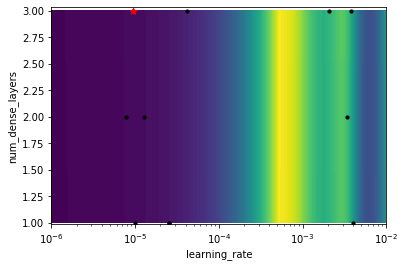

In [74]:
fig = plot_objective_2D(result=search_result,
                        dimension_identifier1='learning_rate',
                        dimension_identifier2='num_dense_layers',
                        levels=100)

In [80]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']
fig, ax = plot_objective(result=search_result, plot_dims=dim_names)

AssertionError: 

ValueError: too many values to unpack (expected 2)

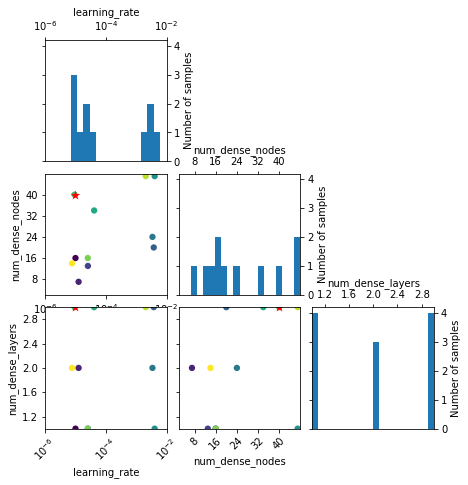

In [81]:
fig, ax = plot_evaluations(result=search_result, plot_dims=dim_names)